In [1]:
!pip install selenium webdriver-manager

In [2]:
import pandas as pd
import numpy as np
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from bs4 import BeautifulSoup
import re
import time
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
#from sklearn.linear_model import LinearRegression
#from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
#from sklearn.preprocessing import StandardScaler
import seaborn as sns


In [3]:
class RealtorScraper:
    def scrape_houses_data(self, page_url, ds_file_name):
        # Set up Selenium
        chrome_options = Options()
        chrome_options.add_argument("--headless")
        service = Service('C:/Users/IBTIHEL/Downloads/chromedriver-win64/chromedriver-win64/chromedriver.exe')
        driver = webdriver.Chrome(service=service, options=chrome_options)
        url = page_url
        driver.get(url)
        
        # Wait for the content to load and then get the page source
        time.sleep(20)
        page_source = driver.page_source

        # Use BeautifulSoup to parse the loaded content
        soup = BeautifulSoup(page_source, "html.parser")
        listings = soup.find_all('div', class_='CardContent__StyledCardContent-rui__sc-7ptz1z-0 kDqsxy card-content card-content')
        
        # Extract data 
        prices=[]
        beds=[]
        baths=[]
        sqfts=[]
        for listing in listings:
            try:
                raw_price = listing.find('div', class_='Pricestyles__StyledPrice-rui__btk3ge-0 kjbIiZ card-price')
                raw_price_text = raw_price.text
                price = int(re.sub(r'[^\d]', '', raw_price_text))
            except AttributeError:
                price = None
            
            try:
                raw_nb_beds= listing.find('li', class_='PropertyBedMetastyles__StyledPropertyBedMeta-rui__a4nnof-0 jkAoUn')
                raw_nb_beds_text = raw_nb_beds.text
                nb_beds = float(re.sub(r'[^\d\.]', '', raw_nb_beds_text))
            except AttributeError:
                nb_beds = None
            
            try:
                raw_nb_baths= listing.find('li', class_='PropertyBathMetastyles__StyledPropertyBathMeta-rui__sc-67m6bo-0 hGQdFx')
                raw_nb_baths_text = raw_nb_baths.text
                nb_baths = float(re.sub(r'[^\d\.]', '', raw_nb_baths_text))
            except AttributeError:
                nb_baths = None

            try:
                raw_sqft = listing.find('li', class_='PropertySqftMetastyles__StyledPropertySqftMeta-rui__sc-1gdau7i-0 cYyTDO')
                raw_sqft_text = raw_sqft.span.text
                sqft = float(re.sub(r'[^\d]', '', raw_sqft_text))
            except AttributeError:
                sqft = None

            prices.append(price)
            beds.append(nb_beds)
            baths.append(nb_baths)
            sqfts.append(sqft)

        # Close the browser after scraping
        driver.quit()
        
        # create a data frame with the scraped data
        data= {
            'num_beds': beds,
            'num_baths': baths,
            'sqft': sqfts,
            'price': prices
        }
        df= pd.DataFrame(data)
        df.to_excel(ds_file_name, index= False )
        return df

In [4]:
class DataFramePreprocessor:
    def __init__(self):
        self.combined_df= pd.DataFrame()
        #self.scaler = StandardScaler()

    def combine_dataframes(self, dataframes):
        big_df= self.combined_df= pd.concat(dataframes, ignore_index= True)
        return big_df
    
    def prepare_great_df_for_regression(self, final_ds, big_df):
        # Dropping rows with missing values
        big_df.dropna(inplace= True)

        # One hot encoding of the number of beds and the number of baths
        encoded_df= pd.get_dummies(big_df, columns=['num_beds', 'num_baths'], prefix=['beds', 'baths'])

        # Scale numerical columns
        #encoded_df['sqft'] = self.scaler.fit_transform(encoded_df['sqft'].values.reshape(-1, 1))
        
        encoded_df.to_excel(final_ds, index=False)
        return encoded_df

In [5]:
class DataVisualizer:
    def __init__(self, dataset):
        self.dataset= dataset
    
    def visualize_data(self):
        # Scatter plot of numerical feature (sqft) against the target variable (price)
        sns.scatterplot(x='sqft', y='price', data=self.dataset)
        plt.title('Scatter Plot of home area vs home price')
        plt.show()
        
        # Box plot of 'num_beds' against 'price'
        sns.boxplot(x='num_beds', y='price', data=self.dataset)
        plt.title('Box Plot of num_beds vs Price')
        plt.show()

        # Box plot of 'num_baths' against 'price'
        sns.boxplot(x='num_baths', y='price', data=self.dataset)
        plt.title('Box Plot of num_baths vs Price')
        plt.show()

In [6]:
class PriceRegressor:
    def regress(self, df):
        # Applying log transformation to the 'price' column
        df['log_price'] = np.log1p(df['price'])  # Using np.log1p to handle zeros

        y= df['log_price']
        X= df.drop(['log_price', 'price'], axis=1) 

        X_train, X_test, y_train, y_test= train_test_split(X, y, test_size= 0.2, random_state= 42)

        #model= RandomForestRegressor(n_estimators=100, random_state=42)  # You can adjust hyperparameters
        #model= LinearRegression()
        #model = DecisionTreeRegressor(random_state=44)
        model= GradientBoostingRegressor(random_state=44)
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        r2 = r2_score(y_test, y_pred)
        
        # Inverse transforming predicted log prices back to the original scale
        y_pred_original_scale = np.expm1(y_pred)

        # Calculating R-squared on original scale
        r2_original_scale = r2_score(np.expm1(y_test), y_pred_original_scale)

        # Printing model evaluation metrics
        print("R-squared Score (Log Scale):", r2)
        print("R-squared Score (Original Scale):", r2_original_scale)
        
        return model

In [7]:
class PricePredictor:
    def __init__(self, trained_model):
        self.trained_model= trained_model

    def predictt(self, new_data, prediction_file): # 'new_data' is a DataFrame with encoded columns
        predictions= self.trained_model.predict(new_data)
        y_pred_original_scale = np.expm1(predictions)
        predictions_df= pd.DataFrame({'predicted_price': y_pred_original_scale})
        
        # Save the predictions to an Excel file
        predictions_df.to_excel(prediction_file, index=False)
        return predictions_df

In [8]:
class Manager:
    def __init__(self):
        self.scraper= RealtorScraper()
        self.preprocessor= DataFramePreprocessor()
        self.regressor= PriceRegressor()
        self.trained_model= None
        self.predictor= None
        self.all_scraped_data= []
        self.visualizer= DataVisualizer(None) # Initialize with None, update after preprocessing

    def manage_complete_tasks(self, page_urls, ds_file_names, new_data, final_ds, prediction_file, new_file):
        # scrape data from multiple pages
        for page_url, ds_file_name in zip(page_urls, ds_file_names):
            scraped_df= self.scraper.scrape_houses_data(page_url, ds_file_name)
            self.all_scraped_data.append(scraped_df)

        # combine all extracted dataframes
        big_df= self.preprocessor.combine_dataframes(self.all_scraped_data)

        # visualize the relationship between the price and each of the independent variables
        self.visualizer= DataVisualizer(big_df)
        self.visualizer.visualize_data()

        # Prepare the great dataset for regression
        big_df= self.preprocessor.prepare_great_df_for_regression(final_ds, big_df)

        # train the random forest model
        self.trained_model= self.regressor.regress(big_df)

        # create price predictor - object from the PricePredictor class
        self.predictor= PricePredictor(self.trained_model)

        # Save the columns after encoding
        columns_to_exclude = ['price','log_price']
        encoded_columns = [col for col in big_df.columns if col not in columns_to_exclude]

        # Apply the same transformations to the new data
        new_data_encoded = pd.get_dummies(new_data, columns=['num_beds', 'num_baths'], prefix=['beds', 'baths'])

        # Realign columns in new data to match the training data
        new_data_encoded = new_data_encoded.reindex(columns=encoded_columns, fill_value=0)

        new_data_encoded.to_excel(new_file, index=False)

        # Predict using the trained model
        predictions = self.predictor.predictt(new_data_encoded, prediction_file)
        return predictions

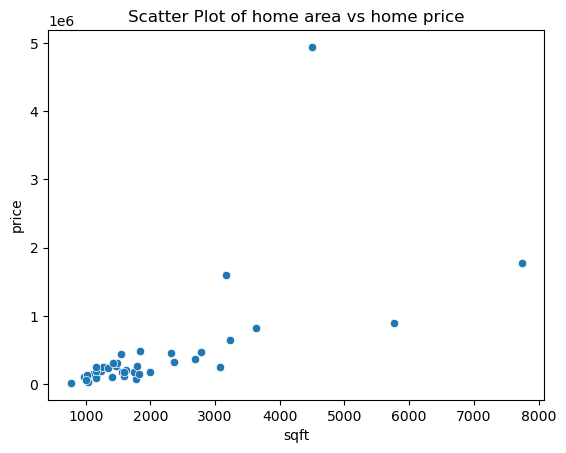

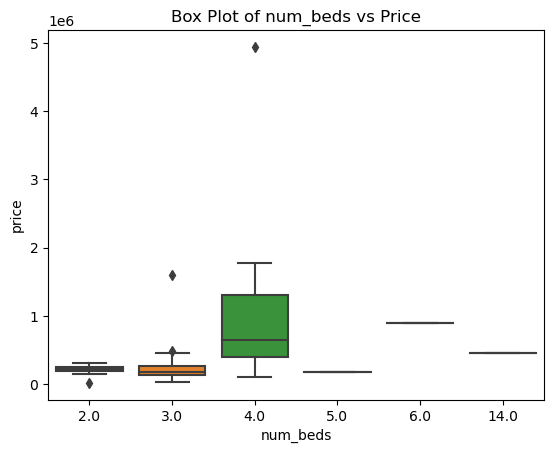

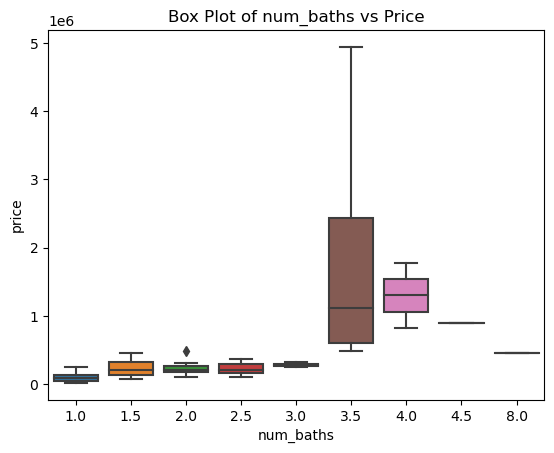

R-squared Score (Log Scale): -3.244138553868855
R-squared Score (Original Scale): -1.2543402584756906


,predicted_price
0,192576.255852
1,279231.980552
2,170492.330149


In [9]:
# create an instance of the manager class
manager_1= Manager()
page_urls1= ['https://www.realtor.com/realestateandhomes-search/Birmingham_AL/show-newest-listings/sby-6',
            'https://www.realtor.com/realestateandhomes-search/Birmingham_AL/show-newest-listings/sby-6/pg-2',
            'https://www.realtor.com/realestateandhomes-search/Birmingham_AL/show-newest-listings/sby-6/pg-3',
            ]
ds_file_names1= ["page_1.xlsx", "page_2.xlsx", "page_3.xlsx"]
new_data1= pd.DataFrame({
    'num_beds': [3.0, 4.0, 1.0],
    'num_baths': [2.0, 3.0, 2.5],
    'sqft': [2000, 2500, 1905]})
final_ds1= "final_ds1.xlsx"
prediction_file1= "prediction_file1.xlsx"
new_file1= "new_file1.xlsx"
prediction_result1= manager_1.manage_complete_tasks(page_urls1, ds_file_names1, new_data1, final_ds1, prediction_file1, new_file1)
prediction_result1